# Notebook projet IF29

Ce Notebook fait office de rendu de code pour le projet d'IF29. Le but étant, à partir d'une base de données de plus de 4 millions de tweets, de réaliser un algorithme supervisé et un non-supervisé afin de classifier les utilisateurs comme suspect ou non.

## Importation des librairies utiles au projet

In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve

from sqlalchemy import (
    create_engine,
    Column,
    String,
    Integer,
    Float,
)
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relationship
import seaborn as sns

## Importation de la base de données JSON
Pour commencer, nous avons parsé les fichiers JSON et récupéré 10 variables par tweets qui nous intéressaient et nous les avons inséré dans une base de donnée SQL via un ORM SQLAlchemy. L'ORM était composé de 2 tables : une pour les users et une pour les tweets.

In [2]:
engine = create_engine("sqlite:///Tweets.db", connect_args={"check_same_thread": False})
Base = declarative_base(bind=engine)
Session = sessionmaker(bind=engine)

class User(Base):
    __tablename__ = "user"

    # Tables des users
    id = Column("id", Integer, primary_key=True)
    id_user = Column("id_user", Integer)
    followers_count = Column("followers_count", Integer)
    friends_count = Column("friends_count", Integer)
    ratio = Column("ratio", Float)
    tweet_length = Column("tweet_length", Float)
    nombre_moyen_url = Column("nombre_moyen_url", Float)
    nombre_moyen_hashtag = Column("nombre_moyen_hashtag", Float)
    fav = Column("fav", Integer)
    agressivite = Column("agressivite", Float)
    visibilite = Column("visibilite", Float)


class Tweet(Base):
    __tablename__ = "tweet"

    # Tables des tweets
    id = Column("id", Integer, primary_key=True)
    id_user = Column("id_user", Integer)
    name_user = Column("name_user", String(500))
    friends_count = Column("friends_count", Integer)
    followers_count = Column("followers_count", Integer)
    text = Column("text", String(500))
    hashtags = Column("hashtags", String(500))
    urls = Column("urls", String(1000))
    fav = Column("fav", Integer)
    user_mentions = Column("user_mentions", String(500))
    timestamp = Column("timestamp", Integer)


Base.metadata.create_all()
session = Session()
if __name__ == "__main__":
    print(session)
    session.commit()

Une fois cette base de données crée, nous avons commencé à la remplir en extrayant JSON par JSON et tweet par tweet les variables qui nous intéressaient et en les stockant dans la db.

In [3]:
#fonction permettant de parser l'intégralité des json et de les stocker dans une base de donnée SQlite
def get_tweet_from_json():
    #boucle pour parcourir les fichier json 1 à 1
    for i in range(0,2286):
        #boucle pour parcourir les lignes et en extraire les tweets
        for line in open('raw'+ str(i) +'.json', 'r', encoding='utf8'):
            tweet_en_cours=json.loads(line)
            id_user = int(tweet_en_cours["user"]['id'])
            name_user = tweet_en_cours["user"]['name']
            friends_count = int(tweet_en_cours["user"]['friends_count'])
            followers_count = int(tweet_en_cours["user"]['followers_count'])
            text = tweet_en_cours["text"]
            #Parcours de la liste des hashtags et concaténation en 1 string
            hashtags = ""
            for item in (tweet_en_cours["entities"]["hashtags"]):
                if hashtags == "":
                    hashtags = item['text']
                else :
                    hashtags+=", " + item['text']
            # Parcours de la liste des urls et concaténation en 1 string
            urls = ""
            for item in (tweet_en_cours["entities"]["urls"]):

                if urls == "":
                    urls = item["url"]
                else:
                    urls += ", " + item["url"]
            user_mentions = len(tweet_en_cours["entities"]["user_mentions"])
            fav = int(tweet_en_cours["user"]['favourites_count'])
            timestamp= tweet_en_cours["timestamp_ms"]
            #stockage dans la db SQlite via l'ORM SQLAlchemy
            try :

                tweet = ORM.Tweet(
                    id_user=id_user,
                    name_user=name_user,
                    friends_count=friends_count,
                    followers_count=followers_count,
                    text=text,
                    hashtags=hashtags,
                    urls=urls,
                    fav=fav,
                    user_mentions=user_mentions,
                    timestamp=timestamp,
                )
                ORM.session.add(tweet)
                ORM.session.commit()
                ORM.session.flush()
                ORM.session.refresh(tweet)
            except Exception as e:
                print(e)
                print("erreur")
        print(i)

Nous avons donc récupéré 4.5 millions de tweets dans notre db SQLITE.

## Transformation en users
On travaille ensuite sur cette db pour en extraire les utilisateurs. Pour raccourcir le temps de traitement, on import dans un premier temps l'ensemble des tweets dans une liste de dictionnaire et on la trie par id_user (id des utilisateurs).

In [4]:
def load_tweet():
    tab_tweet=[]
    # compteur de tweets utilisés
    compteur=0
    #on récupère les données tweets par tweets
    for id, id_user, text, followers_count, friends_count, fav, hashtags, user_mentions, urls, timestamp in ORM.session.query(ORM.Tweet.id, ORM.Tweet.id_user, ORM.Tweet.text, ORM.Tweet.followers_count, ORM.Tweet.friends_count, ORM.Tweet.fav, ORM.Tweet.hashtags, ORM.Tweet.user_mentions, ORM.Tweet.urls, ORM.Tweet.timestamp).all():
        tab_tweet.append({"id":id, "id_user":id_user, "text":text, "followers_count":followers_count, "friends_count":friends_count, "fav":fav, "hashtags":hashtags, "user_mentions":user_mentions, "urls":urls, "timestamp":timestamp})
        compteur+=1
        #on affiche le compteurs tous les 10000
        if compteur % 100000 ==0:
            print(compteur)
    #on trie la liste par id_user
    tab_tweet.sort(key=operator.itemgetter('id_user'))
    print("tri fini")
    #Retourne la liste triée
    return tab_tweet


On donne ensuite la liste triée à la fonction chargée de créer les utilisateurs qui va parcourir les tweets et créer une nouvel utilisateur chaque fois qu'elle rencontre un nouvel id_user.

In [5]:
"""
Permet de créer la base de données des users

Arg : tab : tableau des tweets triés par id_user
Return None
"""
def create_user_table(tab):
    #compteur de tweets utilisés
    compteur=0
    #initialisation id de l'utilisateur traité à l'étape d'avant
    current_id = 0
    #parcours des tweets de la liste
    for rows in tab:
        #Les tweets sont triés par id_user, on regarde donc si le tweet précédent à le même id_user pour le traiter ou le passer
        if current_id==rows['id_user']:
            #le user est déja traité, on ajoute 1 au compteur
            compteur+=1
            #on passe au tweet suivant
            pass

        else :
            # le user n'est déja traité, on le crée et on stocke son user_id dans le comparateur current_id
            current_id=rows['id_user']
            #on vérifie que son friends_count est >0 pour éviter de diviser par 0
            if (rows['friends_count'] != 0):
                indicateur_ratio = rows['followers_count'] / rows['friends_count']
            else:
                indicateur_ratio = rows['followers_count']
            liste_urls = ""
            liste_hashtags = ""
            nombre_user_mentions = 0
            liste_tweets_utilisateur=[]
            liste_tweets_utilisateur.append(rows)
            total_text=0
            compteur_recherche=compteur+1
            #on récupère tous les tweets du même user
            while rows['id_user']==tab[compteur_recherche]['id_user']:
                liste_tweets_utilisateur.append(tab[compteur_recherche])
                compteur_recherche+=1
            #on récupère les hashtags, les urls et la longueur des tweets
            for tweet in liste_tweets_utilisateur:
                if tweet['urls'] != "" and liste_urls=="":
                    liste_urls += tweet['urls']
                elif tweet['urls'] != "" and liste_urls!="":
                    liste_urls += ", " + tweet['urls']
                if tweet['hashtags'] != "" and liste_hashtags=="":
                    liste_hashtags += tweet['hashtags']
                elif tweet['hashtags'] != "" and liste_hashtags!="":
                    liste_hashtags += ", " + tweet['urls']
                nombre_user_mentions+=int(tweet['user_mentions'])
                total_text+=len(tweet['text'])
            avg_text=total_text/len(liste_tweets_utilisateur)
            nombre_urls = len(liste_urls.split(', '))
            avg_urls=nombre_urls/len(liste_tweets_utilisateur)
            #on calcule l'aggressivite
            frequenceFriends=0
            frequenceTweet=1
            if len(liste_tweets_utilisateur)>1:
                liste_timestamp=[]
                for tweet in liste_tweets_utilisateur:
                    liste_timestamp.append(tweet['timestamp'])
                liste_timestamp.sort()
                difftime=(liste_tweets_utilisateur[len(liste_tweets_utilisateur)-1]['timestamp']-liste_tweets_utilisateur[0]['timestamp'])/ float(3600000) + 0.000000000000001
                frequenceTweet= len(liste_tweets_utilisateur)/ difftime
                frequenceFriends = nombre_urls / difftime
            agressivite = (frequenceFriends + frequenceTweet)/350
            #on calcule la visibilté
            moyLengthHashtags = 11.6
            moyLengthMention = 11.4
            nombre_hashtags = len(liste_hashtags.split(","))
            avg_hashtags = nombre_hashtags/len(liste_tweets_utilisateur)
            avg_user_mentions = nombre_user_mentions / len(liste_tweets_utilisateur)
            visibilite= ((avg_hashtags*moyLengthHashtags) + (avg_user_mentions*moyLengthMention))/140
            #on incrémente le compteur
            compteur+=1
            #on stocke le user dans la db
            final_user = ORM.User(id_user=rows['id_user'], followers_count=rows['followers_count'], friends_count=rows['friends_count'], ratio=indicateur_ratio, tweet_length=avg_text, nombre_moyen_url=avg_urls, nombre_moyen_hashtag=avg_hashtags, fav=rows['fav'], agressivite=agressivite, visibilite=visibilite)
            ORM.session.add(final_user)
            ORM.session.commit()
            ORM.session.flush()
            ORM.session.refresh(final_user)
        if compteur % 1000 == 0:
            print(compteur)

On stocke ainsi les users dans notre base de données SQLite. On exporte ensuite la table des users en CSV pour l'utiliser dans notre projet.

## Récupération des données dans un DF Pandas
On récupère les données parsées dans la base SQLite que l'on a exporté dans un .csv puis on enlève les colonnes identifiant et identifiant_user qui ne nous seront pas utiles pour notre analyse. On choisi de ne prendre que 400000 users pour nos traitements car nos machines ne supportent pas le traitement de toute la base.

In [6]:
df = pd.read_csv('Projetif29/user2.csv').drop(["id", "id_user"], axis=1).iloc[500000:900000,:]

## Centrage-réduction des données pour réaliser l'ACP
On centre réduit les données pour supprimer la variabilité des données à cause de leur unité

In [7]:
#On centre réduit les données
s_sc = StandardScaler() 
df_processed = s_sc.fit_transform(df)


## Réalisation de l'ACP
On réalise l'ACP pour réduire la dimensionnalité de notre dataframe, afin de réaliser l'algorithme non-supervisé K-Means. On passe donc de 8 variables à 2 variables qui sont les composantes principales retenues.

In [8]:
#On réalise l'ACP
modelPCA = PCA(n_components=2)
df_reduced = modelPCA.fit_transform(df_processed)

On réaliser maintenant le cercle de corrélations, afin de déceler différentes corréltions entre les variables.

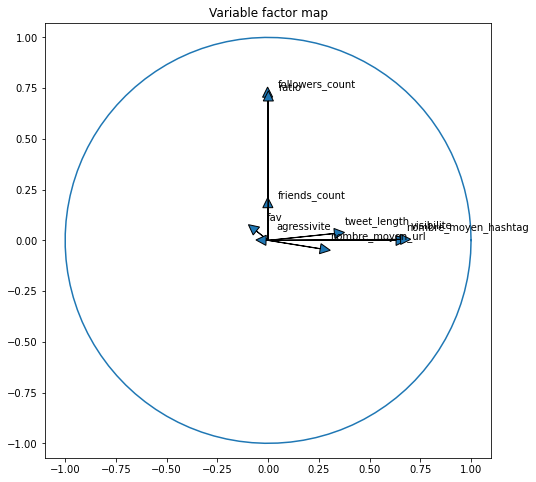

In [9]:
# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, modelPCA.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             modelPCA.components_[0, i],  #0 for PC1
             modelPCA.components_[1, i],  #1 for PC2
             head_width=0.05,
             head_length=0.05)

    plt.text(modelPCA.components_[0, i] + 0.05,
             modelPCA.components_[1, i] + 0.05,
             df.columns.values[i])


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()

On récupère ici les variances expliquées par chaque composante principale afin d'avoir cette indication sur notre graph. On trace donc le graph avec les deux composantes principales comme axes.

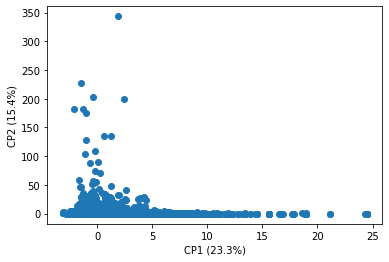

In [10]:
CP1inertie = str(round(round(modelPCA.explained_variance_ratio_[0],3)*100,1))
CP2inertie = str(round(round(modelPCA.explained_variance_ratio_[1],3)*100,1))
xlab = str("CP1 ("+CP1inertie+"%)")
ylab = str("CP2 ("+CP2inertie+"%)")
plt.scatter(df_reduced[:,0],df_reduced[:,1])
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.show()

## Trouver le nombre de clusters pour le K-Means
Pour trouver le nombre de clusters que nous allons prendre pour le K-Means, on réalise la méthode du coude représentant l'inertie en fonction du nombre de clusters.

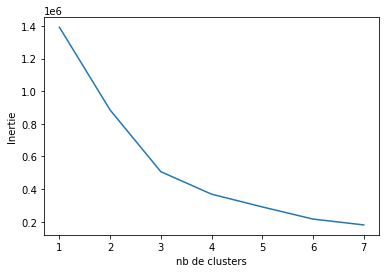

In [11]:
#Elbow method
inertia = []
K_range = range(1, 8)
for i in K_range:
    modelElbow = KMeans(n_clusters=i).fit(df_reduced)
    inertia.append(modelElbow.inertia_)

plt.plot(K_range, inertia)
plt.xlabel('nb de clusters')
plt.ylabel('Inertie')
plt.show()

## K-Means avec 3 clusters
On réalise le K-Means avec 3 clusters, car c'est notre zone de coude

In [12]:
#KMeans with 3 clusters
modelKMeans = KMeans(n_clusters=3)
df_KMeans = modelKMeans.fit(df_reduced)

On trace le graph en donnant une couleur définie à nos clusters

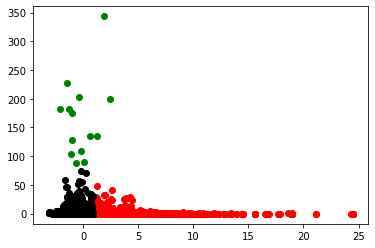

In [13]:
label = modelKMeans.fit_predict(df_reduced)

filtered_label0 = df_reduced[label == 0]
filtered_label1 = df_reduced[label == 1]
filtered_label2 = df_reduced[label == 2]
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'red')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'black')
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'green')
plt.show()

## K-Means avec 6 clusters
Pour plus de représentativité par rapport à la problématique, on réalise un K-Means avec 6 clusters

In [14]:
#KMeans with 6 clusters
modelKMeans = KMeans(n_clusters=6)
df_KMeans = modelKMeans.fit(df_reduced)

On trace le graph avec les 6 clusters en choisissant la couleur de chacun.

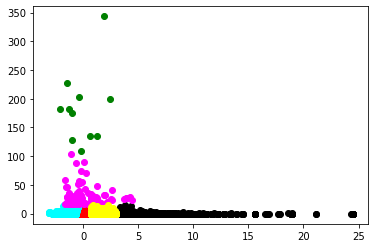

In [15]:
label = modelKMeans.fit_predict(df_reduced)

filtered_label0 = df_reduced[label == 0]
filtered_label1 = df_reduced[label == 1]
filtered_label2 = df_reduced[label == 2]
filtered_label3 = df_reduced[label == 3]
filtered_label4 = df_reduced[label == 4]
filtered_label5 = df_reduced[label == 5]
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'red')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'black')
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'green')
plt.scatter(filtered_label3[:,0] , filtered_label3[:,1] , color = 'cyan')
plt.scatter(filtered_label4[:,0] , filtered_label4[:,1] , color = 'magenta')
plt.scatter(filtered_label5[:,0] , filtered_label5[:,1] , color = 'yellow')
plt.show()

## Labellisation de nos utilisateurs
On labellise les utilisateurs comme suspect ou non en fonction du résultat du K-Means. Le cluster ayant le pourcentage de comptes supprimés le plus élevé est considéré comme étant suspect.

In [16]:
#User from each clusters

cluster0 = pd.DataFrame(df_reduced[df_KMeans.labels_==0])
cluster1 = pd.DataFrame(df_reduced[df_KMeans.labels_==1])
cluster2 = pd.DataFrame(df_reduced[df_KMeans.labels_==2])
cluster3 = pd.DataFrame(df_reduced[df_KMeans.labels_==3])
cluster4 = pd.DataFrame(df_reduced[df_KMeans.labels_==4])
cluster5 = pd.DataFrame(df_reduced[df_KMeans.labels_==5])

cluster0['suspect'] = 0
cluster1['suspect'] = 0
cluster2['suspect'] = 0
cluster3['suspect'] = 1
cluster4['suspect'] = 0
cluster5['suspect'] = 0

 On concatène nos 6 clusters pour creer un dataset final

In [17]:
dataset_label = pd.concat([cluster0, cluster1, cluster2, cluster3, cluster4, cluster5])
dataset_label.to_csv('Projetif29/dataset_label.csv', encoding='utf-8')
dataset_final = np.array(dataset_label)


# SVM
## Séparation des labels
On sépare les variables X de leur label Y

In [18]:
X = dataset_final[:,:-1]
Y = dataset_final[:,-1]

## Répartition Training/Test
On sépare notre jeu de données en 2 sous-datasets, un pour l'entrainement du model et un pour le test, comprenant respectivement 80% et 20% des données prises aléatoirement.

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state = 0)


## Entrainement du model
On entraine tout d'abord le model avec la fonction noyau 'linear'

In [20]:
linear = svm.SVC(kernel='linear')

linear.fit(X_train, Y_train)

SVC(kernel='linear')

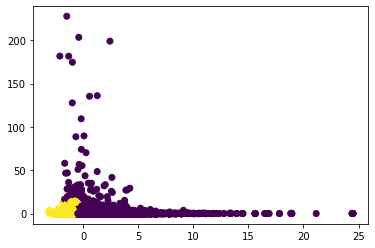

In [21]:
plt.scatter(X_train[:, 0], X_train[:, 1], c = Y_train)
plt.show()

## Test et analyse
On test le model sur nos données test

In [22]:
Y_pred = linear.predict(X_test)

On analyse les résultats avec le dataset de test et on créé le classification report pour la fonction linear

In [38]:
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
pd.DataFrame(classification_report(Y_test,Y_pred, output_dict = True))


Accuracy: 0.99985


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.999872,0.999802,0.99985,0.999837,0.99985
recall,0.999909,0.999723,0.99985,0.999816,0.99985
f1-score,0.999890,0.999763,0.99985,0.999827,0.99985
support,54700.000000,25300.000000,0.99985,80000.000000,80000.00000


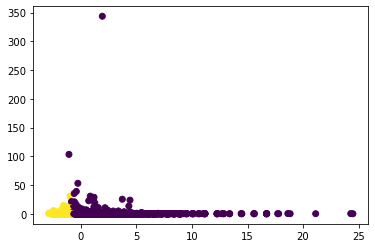

In [24]:
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_pred)
plt.show()

### Confusion Matrix

Matrice de confusion, avec normalisation
[[54680    20]
 [   53 25247]]
Matrice de confusion normalisée
[[9.99634369e-01 3.65630713e-04]
 [2.09486166e-03 9.97905138e-01]]


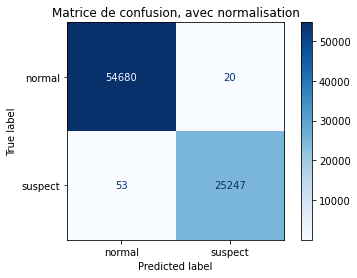

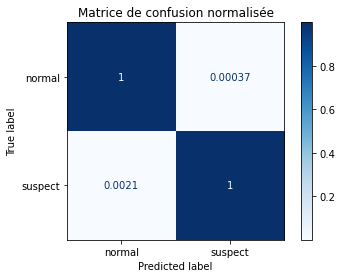

In [25]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Matrice de confusion, avec normalisation", None),
                  ("Matrice de confusion normalisée", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(linear, X_test, Y_test,
                                 display_labels=['normal','suspect'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [26]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54700
         1.0       1.00      1.00      1.00     25300

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000



## SVM avec la fonction poly


In [27]:
poly = svm.SVC(kernel='poly')

poly.fit(X_train, Y_train)

Y_pred = poly.predict(X_test)

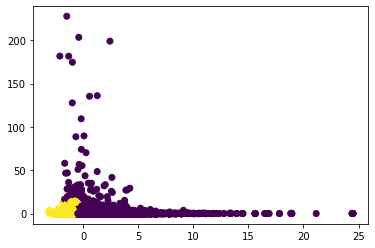

In [28]:
plt.scatter(X_train[:, 0], X_train[:, 1], c = Y_train)
plt.show()

In [29]:
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

Accuracy: 0.9974125


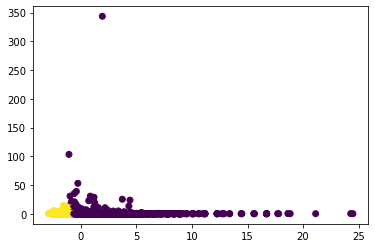

In [30]:
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_pred)
plt.show()

In [31]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(Y_test,Y_pred, output_dict = True))


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.996230,1.000000,0.997413,0.998115,0.997422
recall,1.000000,0.991818,0.997413,0.995909,0.997413
f1-score,0.998111,0.995892,0.997413,0.997002,0.997410
support,54700.000000,25300.000000,0.997413,80000.000000,80000.000000


## SVM avec la fonction rbf 

In [32]:
rbf = svm.SVC(kernel='rbf')

rbf.fit(X_train, Y_train)

Y_pred = rbf.predict(X_test)

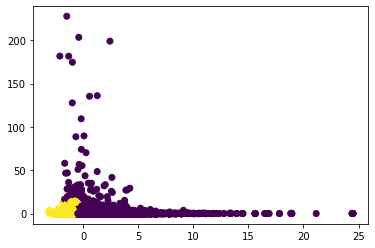

In [33]:
plt.scatter(X_train[:, 0], X_train[:, 1], c = Y_train)
plt.show()

In [34]:
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

Accuracy: 0.99985


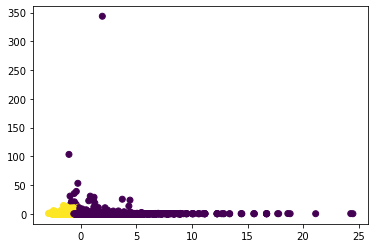

In [35]:
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_pred)
plt.show()

In [36]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(Y_test,Y_pred, output_dict = True))


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.999872,0.999802,0.99985,0.999837,0.99985
recall,0.999909,0.999723,0.99985,0.999816,0.99985
f1-score,0.999890,0.999763,0.99985,0.999827,0.99985
support,54700.000000,25300.000000,0.99985,80000.000000,80000.00000
